In [1]:
import numpy as np
from himalaya.backend import set_backend

from simulation import generate_dataset

set_backend("cupy", on_error="warn")

# disable warnings
import warnings

warnings.filterwarnings("ignore")

In [2]:
feature_space_dimensions = [
    100,  # shared
    100,  # unique 0
    100,  # unique 1
]
scalars = [
    1 / 3,
    1 / 3,
    1 / 3,
]
n_targets = 100
n_samples_train = 1000
n_samples_test = 100
noise = 0.0

cv = 10

In [3]:
(Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(feature_space_dimensions, scalars, n_targets, n_samples_train,
                                                        n_samples_test, noise)

# Variance Partitioning

In [4]:
def vp_errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, feature_space_dimensions, scalars,
                n_targets, n_samples_train, n_samples_test, noise):
    def calculate_yerr(variances, n_samples_train):
        """Calculate the error bars (yerr) for the given variances and training sample size."""
        import numpy as np
        return [np.sqrt(var) / np.sqrt(n_samples_train) for var in variances]

    import matplotlib.pyplot as plt

    # Precompute means and variances
    scores = [score_0, score_1, joint_score, shared, x0_unique, x1_unique]
    means = [s.mean() for s in scores]
    variances = [s.var() for s in scores]
    yerr = calculate_yerr(variances, n_samples_train)

    bar_names = [r"$X_0$", r"$X_1$", r"$X_0 \cup X_1$", r"$X_0 \cap X_1$", r"$X_0 \setminus X_1$",
                 r"$X_1 \setminus X_0$"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
    plt.bar(range(len(means)), means, color=colors, yerr=yerr, capsize=5, ecolor="black")

    plt.xticks(range(len(means)), labels=bar_names)

    # Function to plot horizontal lines
    def plot_horizontal_line(start, end, y_value, label, color):
        plt.plot([start, end], [y_value, y_value], linestyle='--', label=label, color=color)

    # Precompute 'y' values for the lines
    horizontal_positions = [
        (scalars[0] + scalars[1], r"$a_S + a_{U_0}$", -0.5, 0.5),
        (scalars[0] + scalars[2], r"$a_S + a_{U_1}$", 0.5, 1.5),
        (sum(scalars), r"$a_S + a_{U_0} + a_{U_1}$", 1.5, 2.5),
        (scalars[0], r"$a_S$", 2.5, 3.5),
        (scalars[1], r"$a_{U_0}$", 3.5, 4.5),
        (scalars[2], r"$a_{U_1}$", 4.5, 5.5)
    ]

    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

    # Plot all horizontal lines using the extracted function
    for i, (y_value, label, start, end) in enumerate(horizontal_positions):
        plot_horizontal_line(start, end, y_value, label, colors[i])
    plt.legend()

    ylims = plt.gca().get_ylim()
    plt.ylim(ylims[0], 1)
    plt.ylabel("Average Variance Explained")
    plt.xlabel("Feature space")

    plt.suptitle("Variance partitioning")
    plt.title(
        fr"{n_targets} targets, $a_S$: {scalars[0]:.2f}, $|S|$: {feature_space_dimensions[0]}, $a_U0$: {scalars[1]:.2f}, $|U_0|$: {feature_space_dimensions[1]}, $a_U1$: {scalars[2]:.2f}, $|U_1|$: {feature_space_dimensions[2]}, $a_E$: {noise}")
    plt.tight_layout()
    plt.show()

In [5]:
from variance_partitioning import variance_partitioning

In [6]:
(score_0, score_1, joint_score, shared, x0_unique, x1_unique) = variance_partitioning(Xs_train, Xs_test, Y_train,
                                                                                      Y_test, cv=cv)

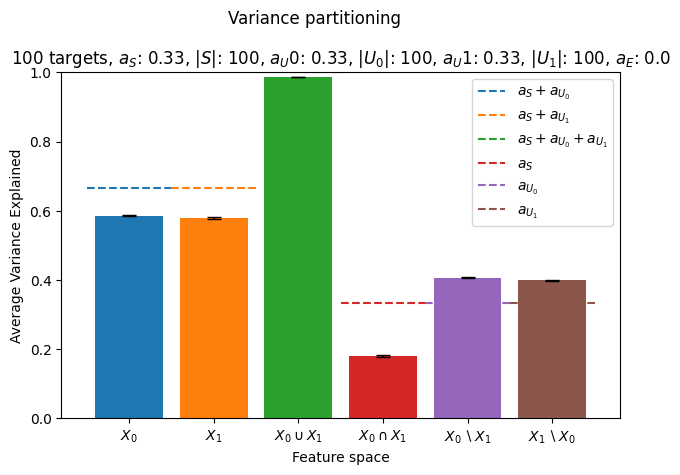

In [7]:
vp_errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, feature_space_dimensions, scalars, n_targets,
            n_samples_train, n_samples_test, noise)

# Residual Method

In [8]:
from residual import residual_method

In [9]:
full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1 = residual_method(
    Xs_train, Xs_test, Y_train, Y_test, use_ols=True, return_full_variance=True, cv=cv)

In [10]:
def rm_errorbar(full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1, feature_space_dimensions, scalars,
                n_targets, n_samples_train, n_samples_test, noise):
    def calculate_yerr(variances, n_samples_train):
        """Calculate the error bars (yerr) for the given variances and training sample size."""
        import numpy as np
        return [np.sqrt(var) / np.sqrt(n_samples_train) for var in variances]

    import matplotlib.pyplot as plt

    # Precompute means and variances
    scores = [full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1]
    means = [s.mean() for s in scores]
    variances = [s.var() for s in scores]
    yerr = calculate_yerr(variances, n_samples_train)

    bar_names = [r"$X_0$", r"$X_1$", r"$f(X_1) \approx X_0$", r"$f(X_0) \approx X_1$", r"$X_0 \setminus X_1$",
                 r"$X_1 \setminus X_0$"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
    plt.bar(range(len(means)), means, color=colors, yerr=yerr, capsize=5, ecolor="black")

    plt.xticks(range(len(means)), labels=bar_names)

    # Function to plot horizontal lines
    def plot_horizontal_line(start, end, y_value, label, color):
        plt.plot([start, end], [y_value, y_value], linestyle='--', label=label, color=color)

    # Precompute 'y' values for the lines
    horizontal_positions = [
        (scalars[0] + scalars[1], r"$a_S + a_{U_0}$", -0.5, 0.5),
        (scalars[0] + scalars[2], r"$a_S + a_{U_1}$", 0.5, 1.5),
        (feature_space_dimensions[0]/(feature_space_dimensions[0] + feature_space_dimensions[1]), r"$\frac{|S|}{|U_0|+|S|}$", 1.5, 2.5),
        (feature_space_dimensions[0]/(feature_space_dimensions[0] + feature_space_dimensions[2]), r"$\frac{|S|}{|U_1|+|S|}$", 2.5, 3.5),
        (scalars[1], r"$a_{U_0}$", 3.5, 4.5),
        (scalars[2], r"$a_{U_1}$", 4.5, 5.5)
    ]

    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

    # Plot all horizontal lines using the extracted function
    for i, (y_value, label, start, end) in enumerate(horizontal_positions):
        plot_horizontal_line(start, end, y_value, label, colors[i])
    plt.legend()

    ylims = plt.gca().get_ylim()
    plt.ylim(ylims[0], 1)
    plt.ylabel("Average Variance Explained")
    plt.xlabel("Feature space/Model")

    plt.suptitle("Residual Method")
    plt.title(
        fr"{n_targets} targets, $a_S$: {scalars[0]:.2f}, $|S|$: {feature_space_dimensions[0]}, $a_{{U_0}}$: {scalars[1]:.2f}, $|U_0|$: {feature_space_dimensions[1]}, $a_{{U_1}}$: {scalars[2]:.2f}, $|U_1|$: {feature_space_dimensions[2]}, $a_E$: {noise}")
    plt.tight_layout()
    plt.show()

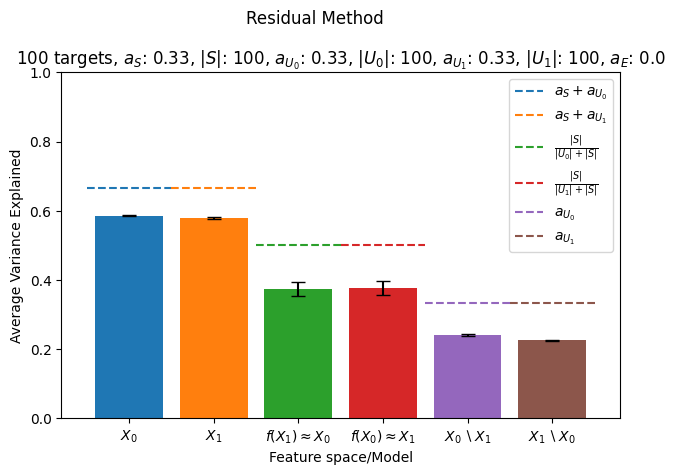

In [11]:
rm_errorbar(full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1, feature_space_dimensions, scalars,
                n_targets, n_samples_train, n_samples_test, noise)

# Dimensions and proportion testing

In [ ]:
for shared_dimension in [10, 100, 1000]:
    dimensions = feature_space_dimensions.copy()
    dimensions[0] = shared_dimension

    _n_samples_train = 2 * sum(dimensions)

    (Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(dimensions, scalars, n_targets, _n_samples_train,
                                                            n_samples_test, noise)
    (score_0, score_1, joint_score, shared, x0_unique, x1_unique) = variance_partitioning(Xs_train, Xs_test, Y_train,
                                                                                          Y_test, cv=cv)
    vp_errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, dimensions, scalars, n_targets,
                _n_samples_train, n_samples_test, noise)

    (full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1) = residual_method(
    Xs_train, Xs_test, Y_train, Y_test, use_ols=True, return_full_variance=True, cv=cv)

    rm_errorbar(full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1, dimensions, scalars, n_targets, _n_samples_train, n_samples_test, noise)


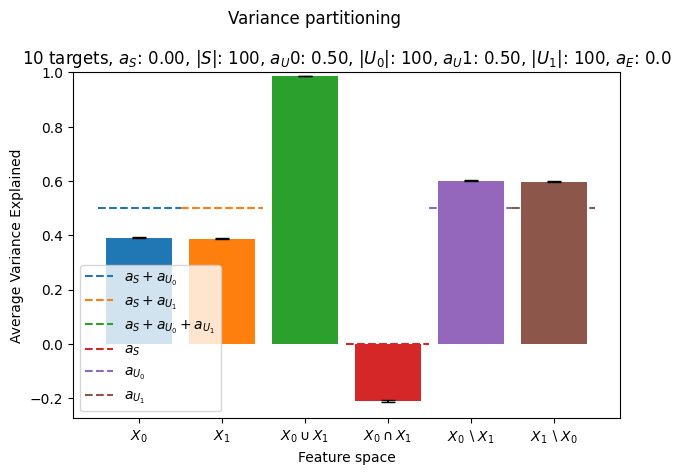

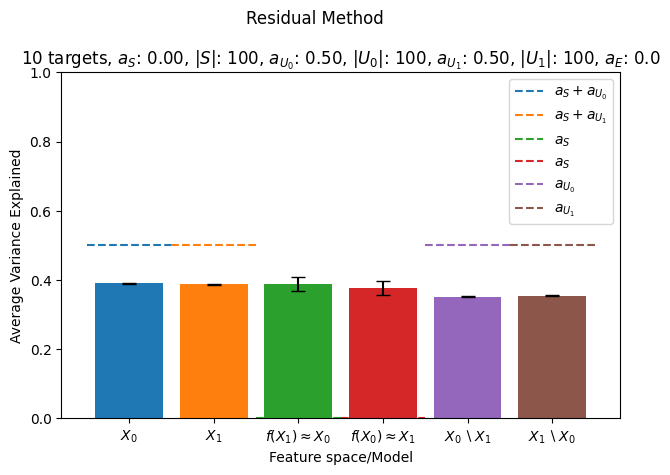

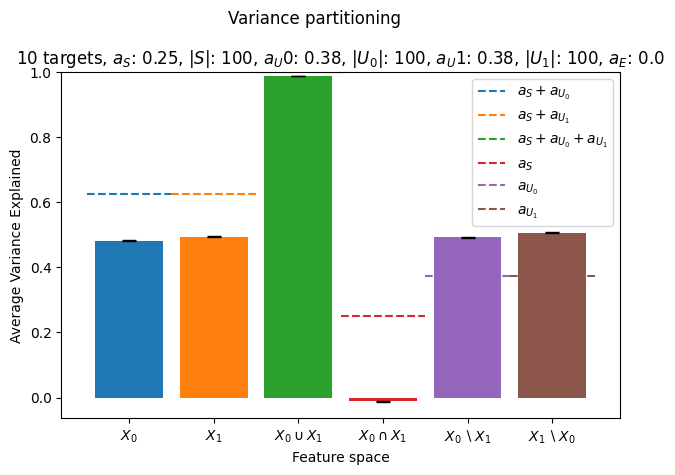

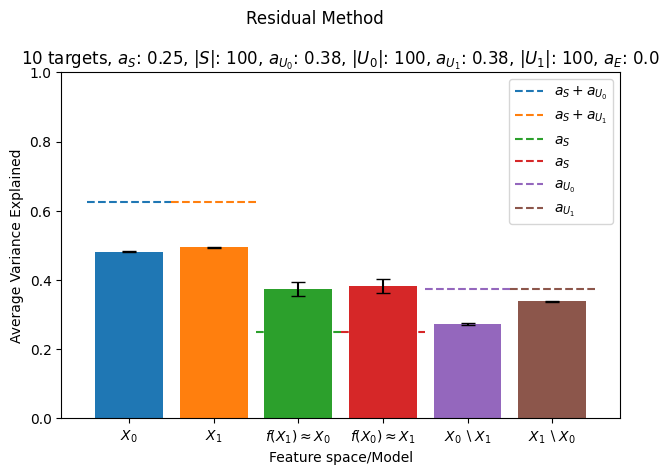

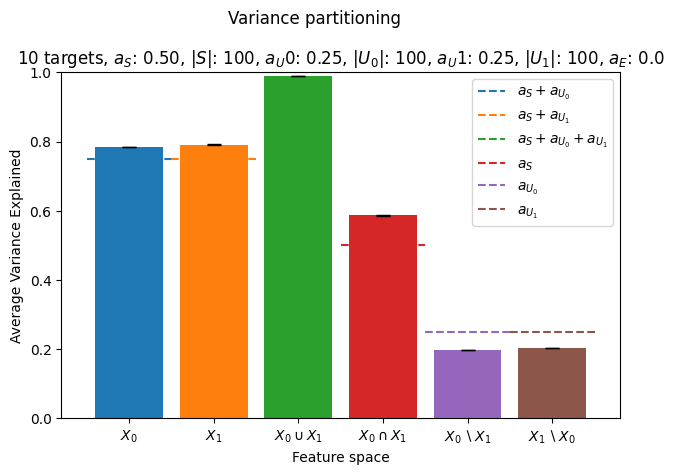

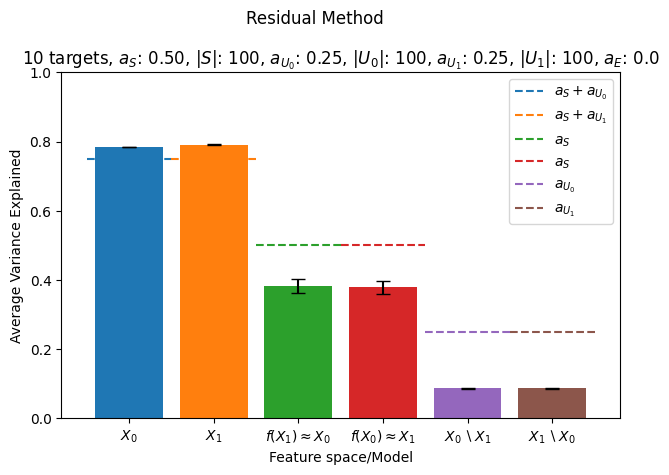

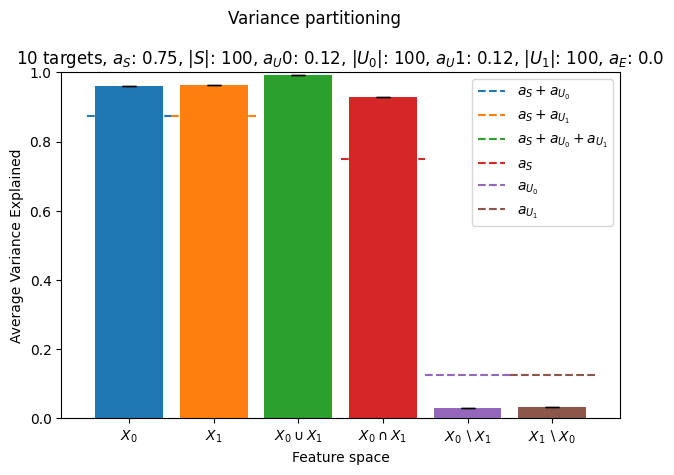

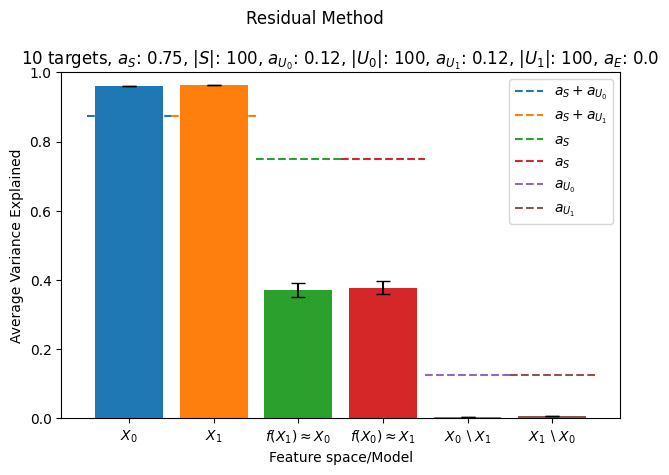

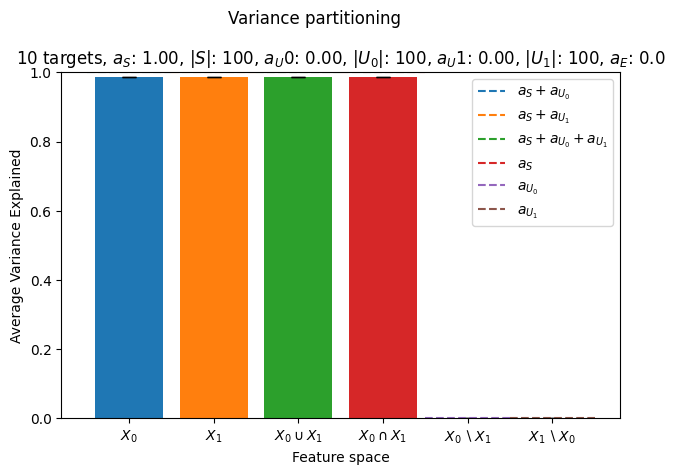

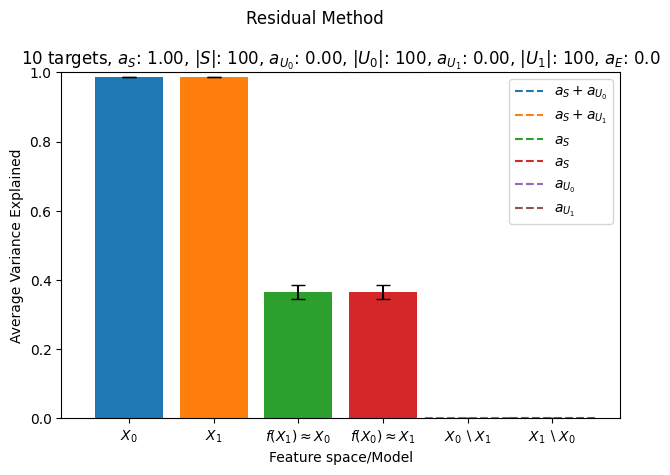

In [13]:
for shared_scalar in np.linspace(0, 1, 5):
    _scalars = [shared_scalar, (1 - shared_scalar) / 2, (1 - shared_scalar) / 2]
    (Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(feature_space_dimensions, _scalars, n_targets,
                                                            n_samples_train, n_samples_test, noise)
    (score_0, score_1, joint_score, shared, x0_unique, x1_unique) = variance_partitioning(Xs_train, Xs_test, Y_train,
                                                                                          Y_test, cv=cv)
    vp_errorbar(score_0, score_1, joint_score, shared, x0_unique, x1_unique, feature_space_dimensions, _scalars,
                n_targets,
                n_samples_train, n_samples_test, noise)

    full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1 = residual_method(
    Xs_train, Xs_test, Y_train, Y_test, use_ols=True, return_full_variance=True, cv=cv)

    rm_errorbar(full_score_0, full_score_1, feature_score_0, feature_score_1, residual_score_0, residual_scores_1, feature_space_dimensions, _scalars, n_targets, n_samples_train, n_samples_test, noise)